In [1]:
import numpy as np
from numpy import pi

from itertools import product

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Operator, Pauli

## Diagonal Unitary Composer

We write a diagonal unitary as 

$$ \Lambda = e^{-i \frac{\pi}{2} \cdot H} $$ 
where $ H = i \cdot \frac{2}{\pi} \cdot \text{log}(U) $. 

Since $ U $ is diagonal, the hermitian matrix $ H $ is diagonal as well and can be decomposed in terms of pauli matrices $ H = \sum_k c_k H_k $ where $ H_k $ is a tensor product of just $ I $ and $ \sigma_z $ operators. This turns out to be a very useful property, since all $ H_k $ terms commute and we can calculate:

$$ \Lambda = e^{-i \frac{\pi}{2} \cdot \sum_k c_k H_k} = \prod_k e^{-i \frac{\pi}{2} \cdot c_k H_k} $$

All that's left to do is find a decomposition of unitary $ U = e^{-i \frac{\phi}{2} (Z \otimes Z)} $ in terms of standard single and two - qubits gates $ Z, R_z $ and $ CX $.

But:

$$ CX \cdot (Z \otimes I) \cdot CX = (Z \otimes Z) \implies CX \cdot (R_z(\phi) \otimes I) \cdot CX = CX \cdot e^{-i \frac{\phi}{2} (Z \otimes I)} \cdot CX = e^{-i \frac{\phi}{2} \cdot CX \cdot (Z \otimes I) \cdot CX} = e^{-i \frac{\phi}{2} (Z \otimes Z)} $$

with a straightforward generalization with $ k $ many $ Z $ terms.

For example, the following circuit calculates $ U = e^{-i \frac{\phi}{2} \cdot Z \otimes Z \otimes Z} $

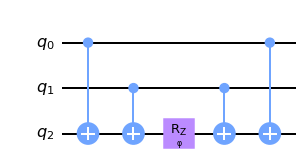

In [2]:
phi = Parameter('φ')

qc = QuantumCircuit(3)

qc.cx(0, 2)
qc.cx(1, 2)
qc.rz(phi, 2)
qc.cx(1, 2)
qc.cx(0, 2)

qc.draw('mpl')

`to_pauli` function decomposes a hermitian diagonal matrix $ H $, with diagonal entries given in a list to save memory,  as a sum of tensor products of $ I $ and $ \sigma_z $ operators.

In [4]:
matrices = {'I': np.array([1,   1]), 
            'Z': np.array([1,  -1])}

def _gen_matrix(paulistring):
    M = 1
    for ps in paulistring:
        M = np.kron(M, matrices[ps])
        
    return M


def to_pauli(H):
    H = H.real
    
    # number of qubits
    n = int(np.log2(len(H)))
    
    # sum of paulis
    Hp = {}
    for label in product('IZ', repeat=n):
        label = ''.join(s for s in label)

        A = _gen_matrix(label)
        coeff = np.sum(A * H) / pow(2, n)
        
        Hp[label] = coeff if np.abs(coeff) > 1e-5 else 0
        
    return Hp

For example:

In [6]:
M = [1, -1, -1, 1]
M = np.array(M, 'complex')

H  = 2j * np.log(M) / np.pi
Hp = to_pauli(H)
Hp

{'II': -1.0, 'IZ': 0, 'ZI': 0, 'ZZ': 1.0}

Putting all together:

In [7]:
def expz(H, theta):
    P = Pauli.from_label(H)
    
    if np.any(P.x):
        print('Invalid input')
        return
    
    qc = QuantumCircuit(P.num_qubits)
    qubits, = np.where(P.z)
    k = len(qubits)
    if k > 0:
        
        if np.allclose(abs(theta), 1):
            
            qc.z(list(qubits))
            qc.global_phase = - np.sign(theta) * np.pi / 2
        
        else:
            
            if abs(theta) % (2 * pi) > 0:
                target = qubits[-1]

                for q in qubits[:-1]:
                    qc.cx(q, target)

                qc.rz(theta * np.pi, target)

                for q in reversed(qubits[:-1]):
                    qc.cx(q, target)
    
    else:
        qc.global_phase = - theta * np.pi / 2
        
    return qc


def diagonal(M):
    # number of qubits
    n = int(np.log2(len(M)))
    
    M = np.array(M, 'complex')
    
    # generator of unitary
    H  = 2j * np.log(M) / np.pi
    Hp = to_pauli(H)
    
    qc = QuantumCircuit(n)
    
    for op, coef in Hp.items():
        qc += expz(op, coef)

    return qc

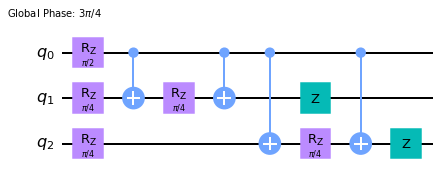

In [8]:
M = [1, -1, -1j, 1, -1j, 1, -1, -1]
qc = diagonal(M)

qc.draw('mpl')

In [9]:
np.allclose(Operator(qc).data, 
            np.diag(M))

True

## Optimize
Let's estimate the cost of our previous approach.

For each term $ U_k = e^{-i \frac{\pi}{2} \cdot c_k H_k} $ with $ m $ $ \sigma_z - $ terms in decomposition of $ H_k $, we have to use $ 2 \cdot (m - 1) $ CNOTs gates. There are $ n \choose m $ such terms, so our total cost is:

$$ \sum_{m=1}^{n} {n \choose m} \cdot 2 (m - 1) = \mathcal{O}\big(n \cdot 2^n\big) $$

But we can do better!

Let's group the terms $H_k$ in 2 groups:

- terms that have the idenity operator $ I $ acting the most significant qubit. This is essentially, a recursive case, with n - 1 number of qubits and hermitian matrix $ \frac{H_1 + H_2}{2} $ , if 
$ H = \begin{bmatrix}
H_1 & 0\\
0 & H_2
\end{bmatrix} $

This can be proven if we write $ H = I \otimes A_I + \sigma_z \otimes A_z \implies H_1 + H_2 = \text{Tr}_n(H) = \text{Tr}(I) \cdot A_I + \text{Tr}(\sigma_z) \cdot A_z = 2 \cdot A_I $,

where $ \text{Tr}_n( . ) $ denotes the partial trace on qubit $ n $.

Similarly, $ H_1 - H_2 = \text{Tr}_n\big( (\sigma_z \otimes I) H \big) = \text{Tr}(\sigma_z) \cdot A_I + \text{Tr}(I) \cdot A_z = 2 \cdot A_z $.

- terms that have $ \sigma_Z $ operator acting on the most significant qubit. This mean that we should implement $ U = e^{-i \frac{\pi}{2} \cdot Z \otimes A_z } $, where $ A_z = \frac{H_1 - H_2}{2} $. After decomposing $ A_z $ into a sum of tensor products of $I, \sigma_z $, we sort the terms in a way that consecutive terms differ in only one position, similar to Gray Code. In this way, consecutive CNOT gates meet and cancel. The only CNOT gate that remains is one controlled from the qubit that just change and target the most significant qubit.

For the second group of terms, we hace $ 2^{n - 1} $ terms in the decomposition of $ A_z $ and we need one CNOT gate between the terms + 1 in the end.

Our new total cost becomes: $ C_n = C_{n - 1} + 2^{n - 1} \implies C_n = 2^n $ in terms of CNOT gates.

In [10]:
def _bin(x, n):
    return bin(x)[2:].zfill(n)


def _gray_code(n):
    
    labels = {'0': 'I', 
              '1': 'Z'}

    gray = []
    for i in range(0, 1 << n):
        x = i ^ (i >> 1)
        x = _bin(x, n)
        
        gray += [''.join(labels[b] for b in x)]
        
    return gray


# return index of control qubits 
def pattern(n):
    if n == 1:
        return [0]
    
    pn = pattern(n - 1)
    
    return pn + [n - 1] + pn

In [11]:
def expz(H):
    n  = len(H)
    nq = int(np.log2(n))
    
    qc = QuantumCircuit(nq)
    
    # 1q - case
    if nq == 1:
        Hp = to_pauli(H)
        
        qc.global_phase = - Hp['I'] * pi / 2
        
        coef = Hp['Z']
        if abs(coef) % (2 * pi) > 0:
            qc.rz(coef * pi, 0)
        
        return qc
        
    # recursive - terms with 'I' in msb qubit
    nh = n // 2

    H1 = (H[:nh] + H[nh:]) / 2
    U1 = expz(H1)
    
    qc.compose(U1, qc.qubits[:-1], 
               inplace=True)
    
    
    # terms with 'Z' in msb qubit
    target = nq - 1
    
    H  = (H[:nh] - H[nh:]) / 2
    Hp = to_pauli(H)
    
    gray = _gray_code(nq - 1)
    controls = pattern(nq - 1) + [nq - 2]
    
    for label, control in zip(gray, controls):
        coef = Hp[label]
        
        if abs(coef) % (2 * pi) > 0:
            qc.rz(coef * pi, 
                  target)
            
        qc.cx(control, 
              target)
        
    return qc


def diagonal(M):
    # number of qubits
    n = int(np.log2(len(M)))
    
    M = np.array(M, 
                 dtype='complex')
    
    # generator of unitary
    H  = 2j * np.log(M) / np.pi
    
    return expz(H)

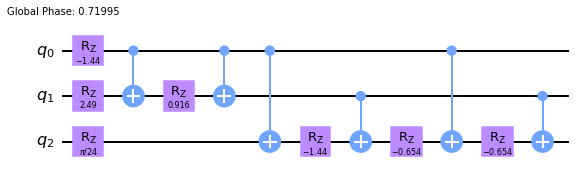

In [12]:
M = [np.exp(1j * pi / 3), -1j, -1, 1, -1j, 1, -1, 1j]
qc = diagonal(M)

qc.draw('mpl')

In [13]:
np.allclose(Operator(qc).data, 
            np.diag(M))

True